# Ciphers 101

A few weekends ago I visited Bletchley Park (BP) in Bucks UK. BP was the headquarters of the British codebreaking operation in World War 2, made famous after the war for their work cracking the German Enigma cipher system. While little remains of the top secret operation (aside from the wooden huts built in the grounds of the house) I was inspired to replicate the Enigma machine in Python and provide it in Jupyter notebook form to allow others to have a go at breaking it (with the help of a modern computer).

This notebook documents my journey over the past few weeks learning about basic ciphers, how they relate to modern algorithms and how the Enigma worked. It's not totally linear and a bit rough but hopefully it'll be interesting for someone else.

*N.B. I am not a mathematician, much less a cryptographer. I wrote this as I find it useful to refresh my probability skills and practice writing but you probably shouldn't rely on any of the information in here. Create a pull request on the repo if you'd like to fix a mistake, suggest a change or make an improvement and I'll do my best to merge it in.*

## Alphabets

First some basics. We start with an alphabet $A$ that represents 26 upper case letters and a space as 27 integer symbols:

$$ A = \{ A=0, B=1, ..., Z=25, \_=26 \} $$

We define a sentence as a list of symbols from $A$:

$$ S_A = [ s_0, s_1, ... s_n ], s_i \in A $$

_N.B. It seems that modern cryptography literature tends to think in terms of bits and bitwise operators when talking about ciphers. I guess that's because modern ciphers operate on blocks of bits. I'm using integer representations of characters because it was quicker to get going that way. Some operations (e.g. the one-time pad) are examined more succinctly in bitwise terms but given that the focus here is on the Enigma machine and basic ciphers, integers will do._


In [1]:
import math
from collections import OrderedDict

import requests

alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ "
unigram_dict = OrderedDict((s, i) for i, s in enumerate(alphabet))


# Get the L-sentence representation of a string
def str_to_l(str):
    return [unigram_dict[x] for x in str]


# Get a string representation of an L-sentence
def l_to_str(indices):
    items = list(unigram_dict.items())
    return ''.join([items[x][0] for x in indices])


l_to_str(str_to_l("ABC XYZ"))

'ABC XYZ'

## Substitution ciphers

A substitution cipher is an encryption function $ E : S_A \rightarrow S_{A^\prime} $  that if it's to be useful should transform the input sentence into an output sentence in such a way that makes it hard to use the contents of the output sentence to predict the contents of the input sentence. In this document we're mainly concerned with ciphers that output symbols from the plaintext alphabet i.e. $ A = A^\prime $ but this doesn't have to be the case. You may have used one of these as a kid and we can represent it as:

$$ E_{\text{sub}}(S_A) : s_i \rightarrow (s_i + n) \bmod |A| , \forall s_i \in S_A $$

In [2]:
def substitution_cipher(plain, n, character_set_size):
    return [(x + n) % character_set_size for x in plain]


def substitution_decipher(cipher, n, character_set_size):
    return [(x - n) % character_set_size for x in cipher]


import random

n = random.randint(1, 26)
plaintext = str_to_l("HELLO WORLD")
ciphertext = substitution_cipher(plaintext, n, len(alphabet))

print(f"{plaintext} -> {ciphertext}")

[7, 4, 11, 11, 14, 26, 22, 14, 17, 11, 3] -> [0, 24, 4, 4, 7, 19, 15, 7, 10, 4, 23]


Now of course this isn't a particularly secure cipher. Assuming that you know a simple substitution cipher is being used, you can brute force all 26 possible settings of $n$ (in your head if you really wanted to) until you recover something that looks like plaintext.

In [3]:
# Try every possible setting of n
for n in range(1, len(alphabet)):
    s = l_to_str(substitution_decipher(ciphertext, n, len(alphabet)))
    print(f"{s}{' ***' if s == l_to_str(plaintext) else ''}")

 XDDGSOGJDW
ZWCCFRNFICV
YVBBEQMEHBU
XUAADPLDGAT
WT  COKCF S
VSZZBNJBEZR
URYYAMIADYQ
TQXX LH CXP
SPWWZKGZBWO
ROVVYJFYAVN
QNUUXIEX UM
PMTTWHDWZTL
OLSSVGCVYSK
NKRRUFBUXRJ
MJQQTEATWQI
LIPPSD SVPH
KHOORCZRUOG
JGNNQBYQTNF
IFMMPAXPSME
HELLO WORLD ***
GDKKNZVNQKC
FCJJMYUMPJB
EBIILXTLOIA
DAHHKWSKNH 
C GGJVRJMGZ
BZFFIUQILFY


## Polygraphic substitution ciphers

Not strictly related to the other ciphers in this document (that are monographic i.e. operating on one input symbol at a time) but an interesting extension of the above. While the _unigram_ (operating on one symbol at a time) substitution cipher is trivial to implement, it is trivially easy to crack as there are only $ |A| $ possible schemes. The unigram substitution cipher can be extended by operating on blocks of $n$ symbols, or _n-grams_. For an alphabet $A$ there are $ |A|^n $ possible n-grams. Setting $n=2$ yields the symbol set:

$$ A_2 = \{ \text{AA} = 0, \text{AB} = 1, ..., \text{\_Z} = 727, \text{\_\_} = 728\}, |A_2| = 729 $$

Substitution ciphers that operate on groups of symbols are known as polygraphic. The cipher below operates on bigrams.

In [4]:
bigrams = [f"{x}{y}" for x in alphabet for y in alphabet]
bigram_dict = OrderedDict((s, i) for i, s in enumerate(bigrams))


# Get the bigram representation of a string
def str_to_bigram(str):
    # Pad odd-length strings with a trailing space
    str = str + " " if len(str) % 2 != 0 else str
    return [bigram_dict[f"{str[(x * 2)]}{str[((x * 2) + 1)]}"] for x in range(0, int(len(str) / 2))]


# Get a string representation of a bigram representation
def bigram_to_str(indices):
    items = list(bigram_dict.items())
    return ''.join([items[x][0] for x in indices]).strip()


bigram_to_str(str_to_bigram("HELLO WORLD"))

'HELLO WORLD'

Using the same brute force technique we used to crack the unigram substitution cipher, we can test all 728 possible settings of $n$. This is still pretty trivial when you've got computer power but as late as World War 2 bigram substitution ciphers were used in the field to encrypt non-critical but time sensitive information as they could be implemented with pen, paper and a compact symbol table.

In [5]:
n_bigram = random.randint(1, len(bigrams))
plaintext = str_to_bigram("HELLO WORLD")
ciphertext = substitution_cipher(plaintext, n_bigram, len(bigrams))

# Try every possible setting of n
for n in range(1, len(bigrams)):
    s = bigram_to_str(substitution_decipher(ciphertext, n, len(bigrams)))
    print(f"{s}{' ***' if s == bigram_to_str(plaintext) else ''}")

Y CGFVNJIGVV
YZCFFUNIIFVU
YYCEFTNHIEVT
YXCDFSNGIDVS
YWCCFRNFICVR
YVCBFQNEIBVQ
YUCAFPNDIAVP
YTB FONCH VO
YSBZFNNBHZVN
YRBYFMNAHYVM
YQBXFLM HXVL
YPBWFKMZHWVK
YOBVFJMYHVVJ
YNBUFIMXHUVI
YMBTFHMWHTVH
YLBSFGMVHSVG
YKBRFFMUHRVF
YJBQFEMTHQVE
YIBPFDMSHPVD
YHBOFCMRHOVC
YGBNFBMQHNVB
YFBMFAMPHMVA
YEBLE MOHLU
YDBKEZMNHKUZ
YCBJEYMMHJUY
YBBIEXMLHIUX
YABHEWMKHHUW
X BGEVMJHGUV
XZBFEUMIHFUU
XYBEETMHHEUT
XXBDESMGHDUS
XWBCERMFHCUR
XVBBEQMEHBUQ
XUBAEPMDHAUP
XTA EOMCG UO
XSAZENMBGZUN
XRAYEMMAGYUM
XQAXELL GXUL
XPAWEKLZGWUK
XOAVEJLYGVUJ
XNAUEILXGUUI
XMATEHLWGTUH
XLASEGLVGSUG
XKAREFLUGRUF
XJAQEELTGQUE
XIAPEDLSGPUD
XHAOECLRGOUC
XGANEBLQGNUB
XFAMEALPGMUA
XEALD LOGLT
XDAKDZLNGKTZ
XCAJDYLMGJTY
XBAIDXLLGITX
XAAHDWLKGHTW
W AGDVLJGGTV
WZAFDULIGFTU
WYAEDTLHGETT
WXADDSLGGDTS
WWACDRLFGCTR
WVABDQLEGBTQ
WUAADPLDGATP
WT  DOLCF TO
WS ZDNLBFZTN
WR YDMLAFYTM
WQ XDLK FXTL
WP WDKKZFWTK
WO VDJKYFVTJ
WN UDIKXFUTI
WM TDHKWFTTH
WL SDGKVFSTG
WK RDFKUFRTF
WJ QDEKTFQTE
WI PDDKSFPTD
WH ODCKRFOTC
WG NDBKQFNTB
WF MDAKPFMTA
WE LC KOFLS
WD

## More complex substitution ciphers

There are $ |A|! $ possible simple substitution schemes (or _permutations_) for a given unigram alphabet. So far we've only looked at shifting plaintext symbols by some fixed amount to yield ciphertext but there are other options. One common strategy (in use for over 400 years) uses a key, shared between sender and receiver (making it a _symmetric_ cipher) to determine the substitution mapping. For example the key $ \text{ENIGMA} $ might describe the following substitution:

$$ \text{ABCDEFGHIJKLMNOPQRSTUVWXYZ_} \rightarrow \text{ENIGMABCDFHJKLNOPQRSTUVWXYZ_} $$



In [6]:
def keyed_substitution_cipher(plain, key):
    substitution_mapping = f"{key}{''.join(c if c not in key else '' for c in alphabet)}"
    return [substitution_mapping.index(x) for x in plain]


def keyed_substitution_decipher(cipher, key):
    substitution_mapping = f"{key}{''.join(c if c not in key else '' for c in alphabet)}"
    return ''.join([substitution_mapping[x] for x in cipher])


key = "ENIGMA"
plain = "HELLO WORLD"
cipher = keyed_substitution_cipher(plain, key)

print(cipher)

keyed_substitution_decipher(cipher, key)[0:1000]

[10, 0, 13, 13, 14, 26, 22, 14, 17, 13, 8]


'HELLO WORLD'

This is an improvement on the simple substitution cipher as the brute force approach from above won't work - They keyspace is too large.

# Polyalphabetic ciphers

Like simple substitution cipher, polyalphabetic ciphers are ciphers that operate on single plaintext symbols and map them to single symbols in the ciphertext. Unlike simple substitution cipher, the polyalphabetic encryption function also takes as an argument the position of the plaintext symbol. In theory in this way we can encrypt the plaintext using a different substitution scheme for each symbol:

$$ E_{\text{poly}}(S_A) : i, s_i \rightarrow \text{key}_i(s_i) , \forall s_i \in S_A $$

Where $\text{key}_i()$ is the substitution function for symbol $i$. The term _key progression_ refers to the mechanism by which the key is determined for each symbol in the plaintext. One of the simplest key progressions can be implemented by taking the simple substitution cipher and making $n$ a function of $i$:

$$ n_i = i $$

In [7]:
def polyalphabetic_cipher(plain, character_set_size):
    return [(x + i) % character_set_size for i, x in enumerate(plain)]


def polyalphabetic_decipher(cipher, character_set_size):
    return [(x - i) % character_set_size for i, x in enumerate(cipher)]


plaintext = str_to_l("HELLO WORLD")
ciphertext = polyalphabetic_cipher(plaintext, len(alphabet))

print(f"{l_to_str(plaintext)} -> {l_to_str(ciphertext)} -> {l_to_str(polyalphabetic_decipher(ciphertext, len(alphabet)))}")

HELLO WORLD -> HFNOSEBVZUN -> HELLO WORLD


This is slightly more secure than the simple substitution cipher but (as we'll see) it's still easy to crack. The fundamental issue is that the key progression is easy to guess (just add one each time). Ideally the key progression of a substitution cipher should be completely unpredictable (a _random permutation_ for each setting of $i$).

It also has a short _period_ i.e. the number of plaintext symbols that can be encrypted before a key gets reused is small. For this cipher it's easy to see that the period is $|A|$.

Interestingly (and from what I can tell) even though they're very different to classical ciphers, modern block ciphers (e.g. AES) are secure as the key space is large, the key progression is securely pseudorandom and the period is extremely long. See [here](https://crypto.stackexchange.com/questions/3867/what-is-difference-between-prg-prf-and-prp) and [here](https://security.stackexchange.com/questions/30170/after-how-much-data-encryption-aes-256-we-should-change-key) for a starting point to learn more about this.

## Frequency analysis

A feature of all of the ciphers discussed so far is that the enciphered message still contains information that can help us recover the plaintext from the ciphertext. Looking at the chipertext generated from the keyed substitution cipher above, the first 5 characters tell us a lot about the structure of the first word

$$ [10, 0, 13, 13, 14] $$

4 different letters are present and one letter appears twice, sequentially in positions 2 and 3. Using a freely available online word list we can start to narrow down the options:

In [8]:
import requests
import pickle


def pkl_cache(loader, key):
    try:
        obj = pickle.load(open(f"{key}.pkl", "rb"))
    except Exception as e:
        print(f"Pickle not found, running loader for key: {key}")
        obj = loader()
        pickle.dump(obj, open(f"{key}.pkl", "wb"))

    return obj


word_list = pkl_cache(
    lambda: requests.get("http://www.mieliestronk.com/corncob_caps.txt").content.decode("utf-8").splitlines(),
    "word_list")
word_list[0:10]

Pickle not found, running loader for key: word_list


['AARDVARK',
 'AARDWOLF',
 'AARON',
 'ABACK',
 'ABACUS',
 'ABAFT',
 'ABALONE',
 'ABANDON',
 'ABANDONED',
 'ABANDONMENT']

In [9]:
[w for w in word_list if len(w) == 5
 and w[2] == w[3]
 and w[0] != w[1]
 and w[1] != w[2]
 and w[0] != w[2]
 and w[3] != w[4]
 and w[0] != w[4]
 and w[1] != w[4]
 ]

['AFOOT',
 'ALOOF',
 'BADDY',
 'BAGGY',
 'BALLS',
 'BANNS',
 'BARRE',
 'BATTY',
 'BELLS',
 'BELLY',
 'BERRY',
 'BEVVY',
 'BILLS',
 'BILLY',
 'BITTS',
 'BITTY',
 'BLEED',
 'BLEEP',
 'BLOOD',
 'BLOOM',
 'BOGGY',
 'BONNY',
 'BOSSY',
 'BREED',
 'BROOD',
 'BROOK',
 'BROOM',
 'BUDDY',
 'BUFFS',
 'BUGGY',
 'BULLS',
 'BULLY',
 'BUNNY',
 'BUTTS',
 'CABBY',
 'CADDY',
 'CALLS',
 'CANNY',
 'CARRY',
 'CELLO',
 'CELLS',
 'CHEEK',
 'CHEEP',
 'CHEER',
 'COMMA',
 'CREED',
 'CREEK',
 'CREEL',
 'CREEP',
 'CROOK',
 'CROON',
 'CUFFS',
 'CULLS',
 'CURRY',
 'DAFFY',
 'DALLY',
 'DELLS',
 'DILLY',
 'DITTO',
 'DITTY',
 'DIZZY',
 'DOGGY',
 'DOLLS',
 'DOLLY',
 'DOTTY',
 'DROOL',
 'DROOP',
 'DULLS',
 'DULLY',
 'DUMMY',
 'FALLS',
 'FANNY',
 'FATTY',
 'FELLS',
 'FERRY',
 'FILLS',
 'FILLY',
 'FIZZY',
 'FLEES',
 'FLEET',
 'FLOOD',
 'FLOOR',
 'FOGGY',
 'FOLLY',
 'FOSSA',
 'FREED',
 'FREES',
 'FULLY',
 'FUNNY',
 'FURRY',
 'FUSSY',
 'FUZZY',
 'GAFFE',
 'GALLS',
 'GASSY',
 'GIDDY',
 'GILLS',
 'GLOOM',
 'GOLLY',
 'GREED',


With a bit of extra context it should be easy to eliminate a lot of the words on the list above and suddenly by looking at just one word of the ciphertext, we can start making some educated guesses about the substitution mapping used. Fundamentally we're exploiting the fact that a simple substitution cipher doesn't alter the frequency distribution of the symbols in the plaintext.

The frequency distribution of characters in typical English text is far from uniform. We can compute our own relative word frequency numbers by taking a long piece of plaintext and counting the number of times each symbol occurs.

In [10]:
import zipfile
import io
import re


def get_wiki_corpus():
    # Download a sample of the wikipedia corpus (~4mb)
    response_bytes = requests.get("https://www.corpusdata.org/wiki/samples/text.zip").content
    zipped = zipfile.ZipFile(io.BytesIO(response_bytes), "r")
    wiki_text = ""

    for file in zipped.infolist():
        wiki_text = wiki_text + zipped.read(file).decode("UTF-8")

    # Uppercase it and remove any unspported characters
    wiki_text = re.sub(" +", " ", "".join(c if c in alphabet else "" for c in wiki_text.upper()))

    return wiki_text


wiki_text = pkl_cache(lambda: get_wiki_corpus(), "wiki_text")

wiki_text[0:1000]

Pickle not found, running loader for key: wiki_text


'TEXTIDTEXT ALBERT OF PRUSSIA MAY MARCH WAS THE LAST GRAND MASTER OF THE TEUTONIC KNIGHTS WHO AFTER CONVERTING TO LUTHERANISM BECAME THE FIRST MONARCH OF THE DUCHY OF PRUSSIA THE SECULARIZED STATE THAT EMERGED FROM THE FORMER MONASTIC STATE OF THE TEUTONIC KNIGHTS ALBERT WAS THE FIRST EUROPEAN RULER TO ESTABLISH PROTESTANTISM AS THE OFFICIAL STATE RELIGION OF HIS LANDS HE PROVED INSTRUMENTAL IN THE POLITICAL SPREAD OF PROTESTANTISM IN ITS EARLY STAGE RULING THE PRUSSIAN LANDS FOR NEARLY SIX DECADES A MEMBER OF THE BRANDENBURGANSBACH BRANCH OF THE HOUSE OF HOHENZOLLERN ALBERT S ELECTION AS GRAND MASTER HAD BROUGHT ABOUT HOPES OF A REVERSAL OF THE DECLINING FORTUNE OF THE TEUTONIC KNIGHTS HE WAS A SKILLED POLITICAL ADMINISTRATOR AND LEADER AND DID INDEED REVERSE THE DECLINE OF THE TEUTONIC ORDER HOWEVER ALBERT WHO WAS SYMPATHETIC TO THE DEMANDS OF MARTIN LUTHER REBELLED AGAINST THE CATHOLIC CHURCH AND THE HOLY ROMAN EMPIRE BY CONVERTING THE TEUTONIC STATE INTO A PROTESTANT AND HEREDITARY

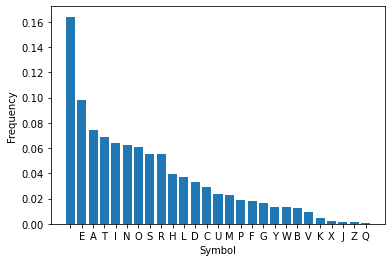

In [11]:
import matplotlib.pyplot as plt


def calculate_symbol_frequency(text, alphabet, plot=False):
    symbol_frequency = {c: 0 for c in alphabet}

    for c in text:
        symbol_frequency[c] = symbol_frequency[c] + 1

    sorted_and_normalised = sorted([(x[0], x[1] / len(text)) for x in symbol_frequency.items()], key=lambda x: x[1],
                                   reverse=True)

    if plot:
        plt.rcdefaults()
        plt.rcParams['figure.figsize'] = [15, 8]
        fig, ax = plt.subplots()
        ax.bar(range(len(sorted_and_normalised)), [x[1] for x in sorted_and_normalised], align='center')
        plt.xticks(range(len(symbol_frequency)), [x[0] for x in sorted_and_normalised])

        ax.set_xlabel("Symbol")
        ax.set_ylabel("Frequency")

        plt.show()

    return sorted_and_normalised


plain_frequencies = calculate_symbol_frequency(wiki_text[0:1_000_000], alphabet, True)

## Shannon Entropy

As we'd expect, the relative frequencies of each letter vary a lot. In the first million characters of the corpus the space symbol is most common, followed by $E$. We can quantify this effect by calculating the Shannon entropy (in bits per symbol) for the process that generated a sentence $S$:

$$ H(S) = - \sum_{s \in S}{p(s)\text{log}_2(p(s))} = \mathbb{E}[-\text{log}_2p(S)] $$

This measures the information content of $S$ or intuitively on average how many bits we need to encode each symbol in $S$ (or even more intuitively: given a yes/no decision tree, on average how many questions would we need to ask to uniquely determine each symbol). At one extreme if a sentence is composed of just one symbol, $\text{log}_2(p(s) = 1) = 0$ and $ H(S) = 0 $ - No information is conveyed by the sentence $S$.

At the other extreme the concavity of the logarithm implies that $ H(S) $ is maximised when $P(s_i)$ is equal for all symbols. This makes intuitive sense - If we're completely unable to predict the next symbol in a sequence, it's conveying the maximum possible amount of information to us.

In [12]:
def shannon_entropy_per_symbol(symbol_frequencies):
    return sum(x * math.log(x, 2) for x in filter(lambda x: x != 0.0, symbol_frequencies)) * -1


print(f"Entropy (bits per symbol): {shannon_entropy_per_symbol([x[1] for x in plain_frequencies])}")

Entropy (bits per symbol): 4.138819297338748


The theoretical maximum entropy per symbol for a sentence composed of alphabet $A$ is $ log_2(|A|) $ or around 4.75 bits for a 27-symbol alphabet. this is quite a bit higher than the entropy calculated above and corresponds with the non-uniform symbol frequency distribution of the English language. Using the keyed substitution cipher from above, we can encrypt the next million characters from the corpus (using a random key) and run the same analysis.

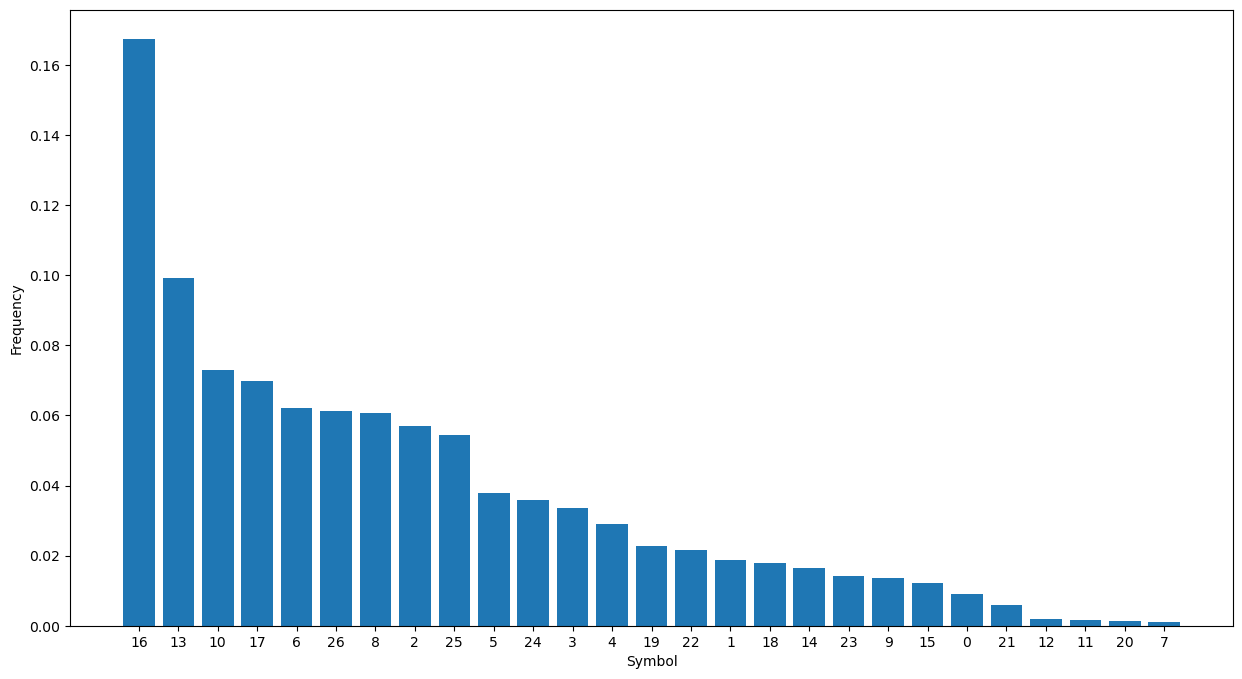

Entropy (bits per symbol): 4.1396378506669524


In [13]:
from random import shuffle

random_key = list(alphabet)
shuffle(random_key)
random_key = "".join(random_key)
cipher = keyed_substitution_cipher(wiki_text[1_000_000:2_000_000], random_key)
cipher_frequencies = calculate_symbol_frequency(cipher, range(len(alphabet)), True)
print(f"Entropy (bits per symbol): {shannon_entropy_per_symbol([x[1] for x in cipher_frequencies])}")

As you'd expect, the distribution has an almost identical shape and entropy as the plaintext. By corresponding the known frequency distribution with the distribution calculated from the ciphertext, we can estimate the mapping function and attempt to decrypt the ciphertext.

In [14]:
calculated_key = "".join(
    [x[0][0] for x in sorted(list(zip(plain_frequencies, cipher_frequencies)), key=lambda x: x[1][0])])
print(f"Predicted key: {calculated_key}")
print(f"Actual key   : {random_key}")
keyed_substitution_decipher(cipher, calculated_key)[0:1000]

Predicted key: VPSDCHIQOWAJXEGB TFUZKMYLRN
Actual key   : VFRDCHIQOWAXJEGY TPMZKUBLSN


'TIER RMYREQMENT WASTIUE DERIGN WOSK ON UU RELPFSOFELLED HOWITZESR WAR CANCELLED OTHESLINKR FSINCE OP WALER HORFITAL IR A SEGIONAL ACMTE FMYLIC HORFITAL LOCATED IN RHA TIN NEW TESSITOSIER IN HONG KONG IT IR ALRO A TEACHING HORFITAL OP THE PACMLTB OP UEDICINE OP THE CHINERE MNIVESRITB OP HONG KONG NAUED APTES AND OPPICIALLB OFENED YB CHASLER FSINCE OP WALER IN FSINCE OP WALER HORFITAL NOW FSOVIDER AFFSOJIUATELB HORFITAL YEDR AND HOMSR ACCIDENT AND EUESGENCB RESVICE WITH AYOMT RTAPP IT IR ALRO THE SEGIONAL HORFITAL SERFONRIYLE POS THE EARTESN NEW TESSITOSIER RESVING RHATIN TAI FO NOSTH NEW TESSITOSIER RAI KMNG AND THE OMTLBING IRLANDR IN EART NEW TESSITOSIER THE HORFITAL IR RMFFOSTED YB THE LI KARHING RFECIALIRT CLINICR POS RFECIALTB OMTFATIENT RESVICER THE HORFITAL GOVESNING COUUITTEE IR THE MLTIUATE DECIRION UAKING AMTHOSITB OP THE HORFITAL THE CMSSENT CHIEP EJECMTIVE OP THE HORFITAL IR DS CHITIU HMNG HIRTOSB POMNDATION THE HIRTOSB OP FSINCE OP WALER HORFITAL IR CONNECTED WITH THAT OP 

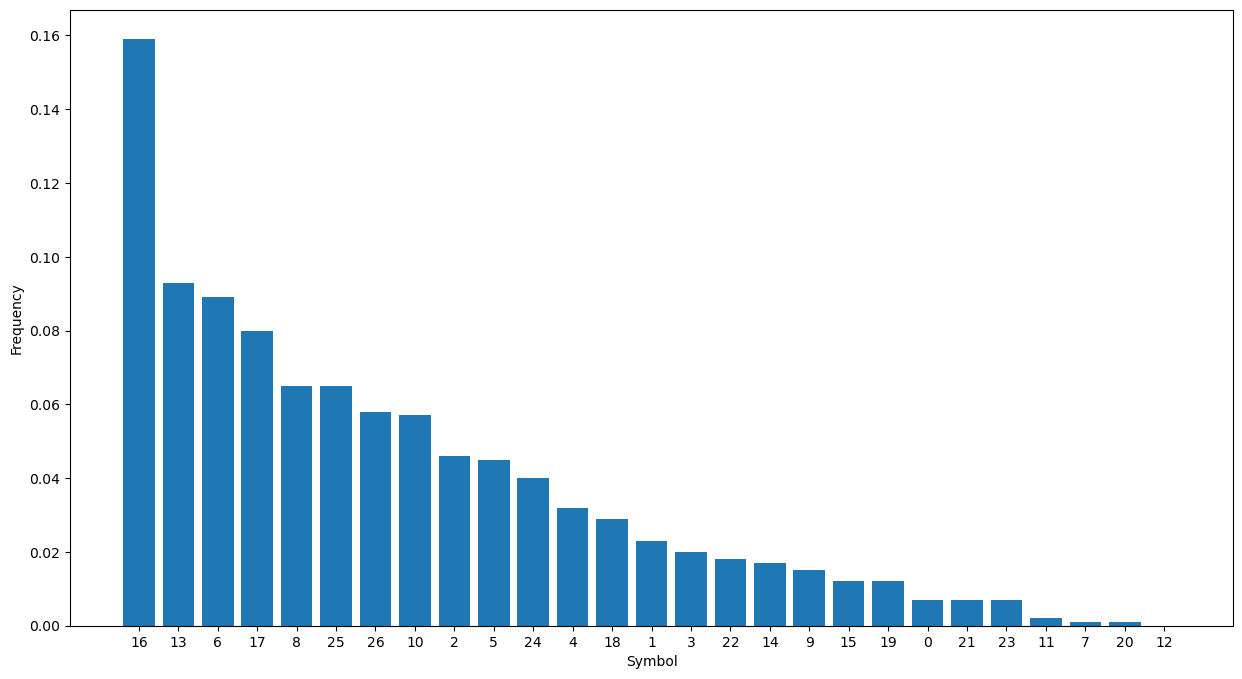

Predicted key: BURMDHAJIGSXQEFY TCWZVPKLNO
Actual key   : VFRDCHIQOWAXJEGY TPMZKUBLSN


'TAEN NPKNEJPEOT GSRTAWE MENAFO GIRV IO WW NELUCRICELLEM HIGATZERN GSN DSODELLEM ITHERLAOVN CRAODE IU GSLEN HINCATSL AN S REFAIOSL SDPTE CPKLAD HINCATSL LIDSTEM AO NHS TAO OEG TERRATIRAEN AO HIOF VIOF AT AN SLNI S TESDHAOF HINCATSL IU THE USDPLTY IU WEMADAOE IU THE DHAOENE POABERNATY IU HIOF VIOF OSWEM SUTER SOM IUUADASLLY ICEOEM KY DHSRLEN CRAODE IU GSLEN AO CRAODE IU GSLEN HINCATSL OIG CRIBAMEN SCCRIXAWSTELY HINCATSL KEMN SOM HIPRN SDDAMEOT SOM EWERFEODY NERBADE GATH SKIPT NTSUU AT AN SLNI THE REFAIOSL HINCATSL RENCIONAKLE UIR THE ESNTERO OEG TERRATIRAEN NERBAOF NHSTAO TSA CI OIRTH OEG TERRATIRAEN NSA VPOF SOM THE IPTLYAOF ANLSOMN AO ESNT OEG TERRATIRAEN THE HINCATSL AN NPCCIRTEM KY THE LA VSNHAOF NCEDASLANT DLAOADN UIR NCEDASLTY IPTCSTAEOT NERBADEN THE HINCATSL FIBEROAOF DIWWATTEE AN THE PLTAWSTE MEDANAIO WSVAOF SPTHIRATY IU THE HINCATSL THE DPRREOT DHAEU EXEDPTABE IU THE HINCATSL AN MR DHATAW HPOF HANTIRY UIPOMSTAIO THE HANTIRY IU CRAODE IU GSLEN HINCATSL AN DIOOEDTEM GATH THST IU 

In [15]:
cipher = keyed_substitution_cipher(wiki_text[1_000_000:1_001_000], random_key)
cipher_frequencies = calculate_symbol_frequency(cipher, range(len(alphabet)), True)
calculated_key = "".join(
    [x[0][0] for x in sorted(list(zip(plain_frequencies, cipher_frequencies)), key=lambda x: x[1][0])])
print(f"Predicted key: {calculated_key}")
print(f"Actual key   : {random_key}")
keyed_substitution_decipher(cipher, calculated_key)[0:1000]

The key we've calculated is fairly different to the true key and the generated plaintext looks much less like English. Comparing the symbol distribution with that calculated from the longer ciphertext reveals the problem. The symbol distributions of short lengths of text can vary significantly from the large-sample distribution and means that as the length of the ciphertext falls, frequency analysis becomes a less useful tool - Having said that, this is still pretty trivially crackable for the determined attacker.

I haven't run the analysis here but it's worth noting that frequency analysis is even more effective when used to crack bigram substitution ciphers as the ciphertext frequency distribution is even less uniform, with a smaller set of bigrams making up more of the total density.

# One-time pads

One-time pads are an interesting class of polyalphabetic cipher as they have a uniform ciphertext symbol distribution and are the only cipher proven uncrackable if implemented correctly. They aren't strictly relevant to the Enigma but are simple and demonstrate some interesting principles.

A one-time pad encrypts plaintext $S$ with a key $K$ of length $|S|$ that contains (for each symbol in the plaintext) a random integer between 0 and $|L|$ that is used to generate ciphertext:

$$ E_{\text{otp}}(S_, K) : s_i, k_i \rightarrow (s_i + k_i) \bmod |L| , \forall s_i \in S, k_i \in K $$

The period of the key progression is infinite as long as we don't reuse the pad. Additionally assuming that a high quality source of randomness is used to generate the pad, the key progression is also completely unpredictable.

A few details:

1. The key must be generated using a secure source of randomness. In the extreme case a key $[0, ..., 0]$ is clearly useless but any non-randomness in the keystream will result in ciphertext with non-uniform symbol frequency distribution which enables a ciphertext attack.
2. The key must never be used to encipher more than one piece of plaintext. If we do we're back to using a cipher with a finite key period.
3. One-time pads are normally presented using the $\text{XOR}$ operator to encrypt and decrypt by performing $s \oplus k$ for each character in the message and key instead of modular addition. I _think_ the analysis is otherwise identical.

In [16]:
def random_string(length, alphabet):
    return [random.randint(0, len(alphabet) - 1) for _ in range(length)]  # Note insecure source of randomness


def one_time_pad_cipher(plain, key, alphabet):
    return [(c + key[i % len(key)]) % len(alphabet) for i, c in enumerate(plain)]


def one_time_pad_decipher(cipher, key, alphabet):
    return [(c - key[i % len(key)]) % len(alphabet) for i, c in enumerate(cipher)]


plain = "HELLO WORLD"

otp_key = random_string(len(plain), alphabet)
cipher = one_time_pad_cipher(str_to_l(plain), otp_key, alphabet)
l_to_str(one_time_pad_decipher(cipher, otp_key, alphabet))

'HELLO WORLD'

We can encrypt the Wikipedia corpus with our OTP and inspect the ciphertext symbol frequency distribution and see that it looks very different to the symbol distribution of ciphertext encrypted with the substitution cipher.

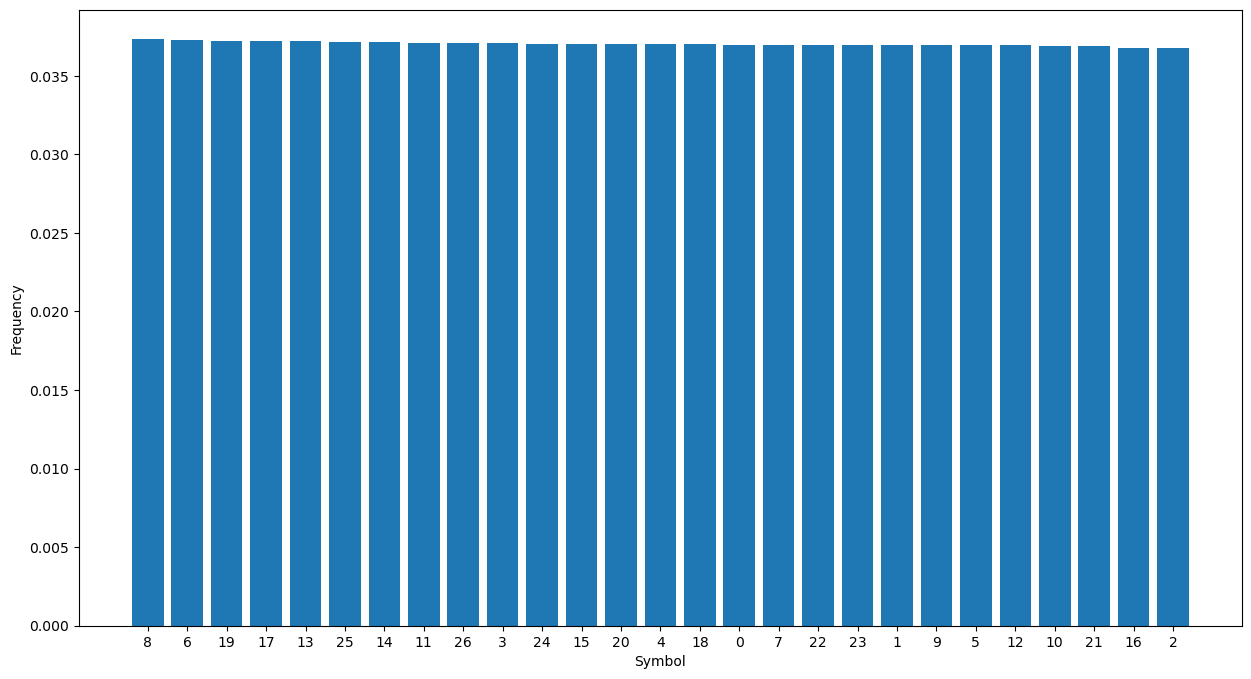

Entropy (bits per symbol): 4.754877154619588


In [17]:
otp_key = random_string(len(wiki_text[0:1_000_000]), alphabet)
cipher = one_time_pad_cipher(str_to_l(wiki_text[0:1_000_000]), otp_key, alphabet)
cipher_frequencies = calculate_symbol_frequency(cipher, range(len(alphabet)), True)
print(f"Entropy (bits per symbol): {shannon_entropy_per_symbol([x[1] for x in cipher_frequencies])}")

It's almost flat and the entropy per symbol has increased to around 4.75 bits - equivalent to a random string drawn from $N$. None of the information encoded in the symbol distribution of the plaintext is present in the ciphertext and as a result we won't get anywhere trying to crack this cipher using just a ciphertext attack.

## Enigma

After a brief detour we arrive at the main event. Full disclosure I am yet to try it myself but my hope is that the reader will be able to figure out a way to crack the Enigma emulator below. The Enigma machine is a complex polyalphabetic substitution cipher that operates on a 26 character alphabet.

I've modelled the Enigma I (M3), the model used most widely by German army command during WW2. It features rotors I, II, III, IV and V which can be ordered in $5!$ different combinations. Each rotor can be set in one of 26 different starting positions (spaces were typically encoded as the character $X$) and the plugboard can be configured in approximately 100 billion combinations when used with 6 leads.

The keyspace is thus rather large and the period of the key progression is $26*26*25 = 16900$, much longer than a typical message. The ring settings are implemented although they don't increase the complexity of the key progression.

**N.B. the output of this doesn't agree with what Wikipedia suggests the output should be for a similarly configured Enigma. As far as I can tell it works but I've run out of time to figure out what exactly is wrong. If anyone knows, please let me know.**

In [18]:
# M3 Enigma emulator

az = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

# Rotors i, ii, iii, iv, v
rotors = [
    "EKMFLGDQVZNTOWYHXUSPAIBRCJ",
    "AJDKSIRUXBLHWTMCQGZNPYFVOE",
    "BDFHJLCPRTXVZNYEIWGAKMUSQO",
    "ESOVPZJAYQUIRHXLNFTGKDCMWB",
    "VZBRGITYUPSDNHLXAWMJQOFECK"
]

# Notches determine rotor turnover points
notches = [16, 4, 21, 9, 25]

# Reflectors A, B, C
reflectors = [
    "EJMZALYXVBWFCRQUONTSPIKHGD",
    "YRUHQSLDPXNGOKMIEBFZCWVJAT",
    "FVPJIAOYEDRZXWGCTKUQSBNMHL"
]

def default_state():
    return {
    "rotor_order": [0, 1, 2],
    "rotor_offsets": [0, 0, 0],
    "ring_settings": [0, 0, 0],
    "reflector": 1,
    "plugboard_settings": []
}


# Simulate a keypress, returning the ciphertext and new rotor settings
def enigma(symbols, enigma_state):

    rotor_order = enigma_state["rotor_order"]
    rotor_offsets = enigma_state["rotor_offsets"]
    ring_settings = enigma_state["ring_settings"]
    reflector = enigma_state["reflector"]
    plugboard_settings = enigma_state["plugboard_settings"]

    enigma_output = []

    for symbol in symbols:

        # Calculate rotor offsets on keypress
        if rotor_offsets[2] == notches[rotor_order[2]]: # If the fast rotor is in the notch, move the middle rotor
            rotor_offsets[1] = (rotor_offsets[1] + 1) % 26
        else: # If the middle rotor is in the notch it advances along with the slow rotor
            if rotor_offsets[1] == notches[rotor_order[1]]:
                rotor_offsets[1] = (rotor_offsets[1] + 1) % 26
                rotor_offsets[0] = (rotor_offsets[0] + 1) % 26

        rotor_offsets[2] = (rotor_offsets[2] + 1) % 26 # Right rotor always steps

        # Rotate the rotors to the offset
        rotor_1 = f"{rotors[rotor_order[2]][rotor_offsets[2]:]}{rotors[rotor_order[2]][0:rotor_offsets[2]]}"
        rotor_2 = f"{rotors[rotor_order[1]][rotor_offsets[1]:]}{rotors[rotor_order[1]][0:rotor_offsets[1]]}"
        rotor_3 = f"{rotors[rotor_order[0]][rotor_offsets[0]:]}{rotors[rotor_order[0]][0:rotor_offsets[0]]}"

        # Apply ring settings
        rotor_1 = f"{rotor_1[ring_settings[2]:]}{rotor_1[0:ring_settings[2]]}"
        rotor_2 = f"{rotor_2[ring_settings[1]:]}{rotor_2[0:ring_settings[1]]}"
        rotor_3 = f"{rotor_3[ring_settings[0]:]}{rotor_3[0:ring_settings[0]]}"

        # Through the plugboard
        plugboard_output =  next(iter([x[1] for x in plugboard_settings if x[0] == symbol]), None) or symbol

        # Send the symbol through the rotors and reflector
        rotor_1_output = rotor_1[az.index(plugboard_output)]
        rotor_2_output = rotor_2[az.index(rotor_1_output)]
        rotor_3_output = rotor_3[az.index(rotor_2_output)]

        # Through the reflector
        reflector_output = reflectors[reflector][az.index(rotor_3_output)]

        # Back through the rotors in reverse order
        rotor_3_output_2 = az[rotor_3.index(reflector_output)]
        rotor_2_output_2 = az[rotor_2.index(rotor_3_output_2)]
        rotor_1_output_2 = az[rotor_1.index(rotor_2_output_2)]

        # And finally through the plugboard
        plugboard_output_2 = next(iter([x[0] for x in plugboard_settings if x[1] == rotor_1_output_2]), None) or rotor_1_output_2

        enigma_output.append(plugboard_output_2)

        # Update state with new rotor positions
        enigma_state["rotor_offsets"] = rotor_offsets

    return enigma_output, enigma_state


enigma_encrypted = enigma("AAAAA", default_state())[0]
print(enigma_encrypted)
print(enigma(enigma_encrypted, default_state())[0])

['D', 'H', 'L', 'X', 'O']
['A', 'A', 'A', 'A', 'A']


We can encrypt the Wikipedia corpus using the default machine configuration (no plugboard substitutions) and see what happens.

In [19]:
# Filter spaces and encrypt using Enigma
wiki_enigma_encrypted = enigma([x for x in wiki_text[0:100_000] if x != " "], default_state())[0]

# Decrypt and print
''.join(enigma(wiki_enigma_encrypted, default_state())[0])[0:1000]

'TEXTIDTEXTALBERTOFPRUSSIAMAYMARCHWASTHELASTGRANDMASTEROFTHETEUTONICKNIGHTSWHOAFTERCONVERTINGTOLUTHERANISMBECAMETHEFIRSTMONARCHOFTHEDUCHYOFPRUSSIATHESECULARIZEDSTATETHATEMERGEDFROMTHEFORMERMONASTICSTATEOFTHETEUTONICKNIGHTSALBERTWASTHEFIRSTEUROPEANRULERTOESTABLISHPROTESTANTISMASTHEOFFICIALSTATERELIGIONOFHISLANDSHEPROVEDINSTRUMENTALINTHEPOLITICALSPREADOFPROTESTANTISMINITSEARLYSTAGERULINGTHEPRUSSIANLANDSFORNEARLYSIXDECADESAMEMBEROFTHEBRANDENBURGANSBACHBRANCHOFTHEHOUSEOFHOHENZOLLERNALBERTSELECTIONASGRANDMASTERHADBROUGHTABOUTHOPESOFAREVERSALOFTHEDECLININGFORTUNEOFTHETEUTONICKNIGHTSHEWASASKILLEDPOLITICALADMINISTRATORANDLEADERANDDIDINDEEDREVERSETHEDECLINEOFTHETEUTONICORDERHOWEVERALBERTWHOWASSYMPATHETICTOTHEDEMANDSOFMARTINLUTHERREBELLEDAGAINSTTHECATHOLICCHURCHANDTHEHOLYROMANEMPIREBYCONVERTINGTHETEUTONICSTATEINTOAPROTESTANTANDHEREDITARYREALMTHEHISUNCLETHEKINGOFPOLANDTHEARRANGEMENTWASCONFIRMEDBYTHETREATYOFKRAKWINALBERTPLEDGEDAPERSONALOATHTOTHEKINGANDINRETURNWASINVESTEDWITHTHEDUCHYFORHIMSELFANDHI

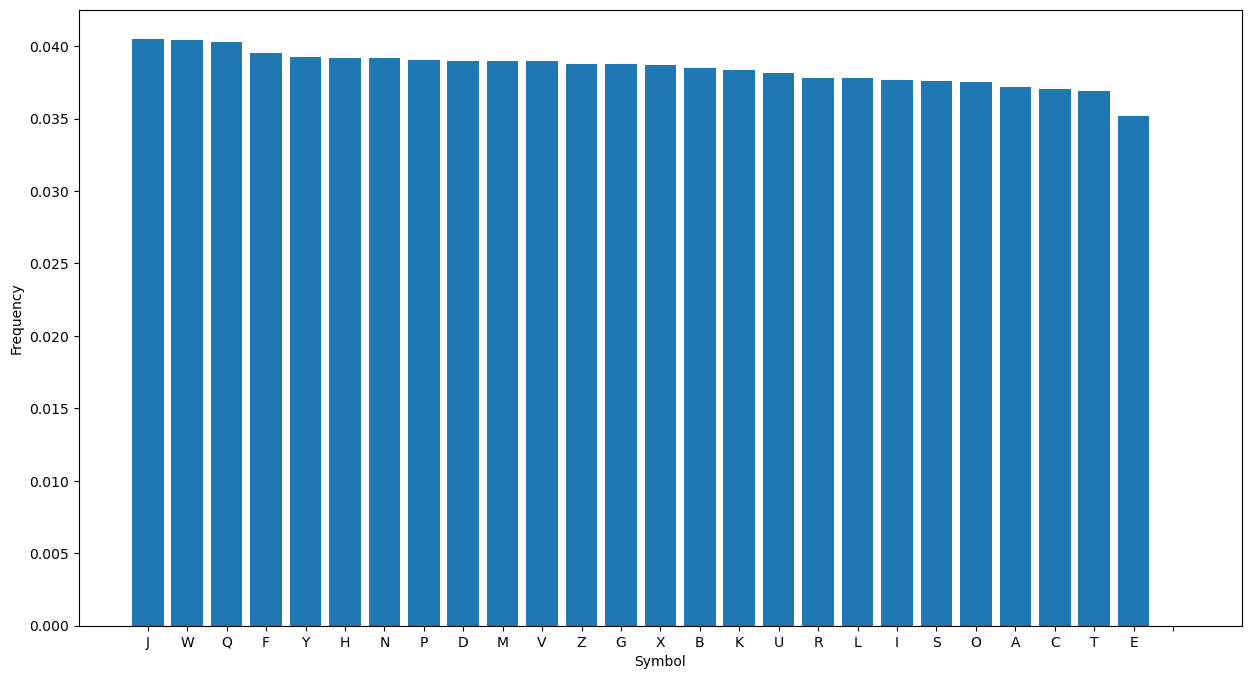

Entropy (bits per symbol): 4.69976685397679


In [20]:
wiki_enigma_frequencies = calculate_symbol_frequency(wiki_enigma_encrypted, alphabet, True)
print(f"Entropy (bits per symbol): {shannon_entropy_per_symbol([x[1] for x in wiki_enigma_frequencies])}")

The entropy per symbol of the Enigma ciphertext is very close to $log_2(26) \approx 4.7 $ (there are only 26 symbols in the Enigma alphabet) and the symbol distribution is close (but not quite) to a uniform distribution. Note that we've encrypted a message much longer than the period of the cipher (which in practice would never be done) which should make it easier to crack.

There's plenty of info on the internet about the methods used to break Enigma during WW2. I would assume that access to modern computers make it easier but as mentioned, that's left as an exercise to the reader. I hope this has been an enjoyable read, that you've learned something new and look forward to seeing what people come up with. Almost all comments, queries and feedback is welcome (particularly if you're actually a cryptographer) and I'll do my best to merge the changes.

H

# Other links

[Wiki - Substitution ciphers](https://en.wikipedia.org/wiki/Substitution_cipher)

[Wiki - Polygraphic substitution](https://en.wikipedia.org/wiki/Polygraphic_substitution)

[Wiki - Polyalphabetic substitution cipher](https://en.wikipedia.org/wiki/Polyalphabetic_cipher)

[Wiki - Shannon Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory))

[Wiki - Enigma Machine](https://en.wikipedia.org/wiki/Enigma_machine)

[Wiki - Cryptanalysis of the Enigma](https://en.wikipedia.org/wiki/Cryptanalysis_of_the_Enigma)

[Enigma emulator](https://www.101computing.net/enigma-machine-emulator/)

[3D Enigma emulator](https://enigma.virtualcolossus.co.uk/)